In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import chi2, f

In [2]:
#1
amit = pd.read_csv('amit.dat', header=None, delim_whitespace=True)
amit.columns=['Y1','Y2','Z1','Z2','Z3','Z4','Z5']
amit
#n = 17 patients
#m = 2 response variables
#r = 5 predictor variables

,Y1,Y2,Z1,Z2,Z3,Z4,Z5
0,3389,3149,1,7500,220,0,140
1,1101,653,1,1975,200,0,100
2,1131,810,0,3600,205,60,111
3,596,448,1,675,160,60,120
4,896,844,1,750,185,70,83
5,1767,1450,1,2500,180,60,80
6,807,493,1,350,154,80,98
7,1111,941,0,1500,200,70,93
8,645,547,1,375,137,60,105
9,628,392,1,1050,167,60,74


In [3]:
#(a) Perform multivariate regression analysis. Analyze residuals to check multivariate normal assumption
def mv_reg_anal(data, m, r): #m: number of response var, r: number of predictor var
    y_colnames=data.columns[0:m]
    z_colnames=data.columns[m:(m+r)]
    Y=data[y_colnames]
    Z=data[z_colnames]
    ones=pd.DataFrame(np.ones(len(data),dtype=np.int8))
    ones.columns=['Z0']
    ones
    Z=pd.concat([ones,Z],axis=1)
    
    B_hat=pd.DataFrame((np.linalg.inv(Z.T.dot(Z))).dot(Z.T).dot(Y))
    
    return [Y, Z, B_hat]

In [4]:
#B_hat matrix
#B0: intercept
#B1~B5: slope for Z1~Z5
Y, Z, B_hat=mv_reg_anal(amit, 2, 5)
B_hat.index = ['Z0','Z1','Z2','Z3','Z4','Z5']
B_hat.columns = ['Y1','Y2']
B_hat

,Y1,Y2
Z0,-2879.478246,-2728.708544
Z1,675.650781,763.029762
Z2,0.284851,0.306373
Z3,10.272133,8.896198
Z4,7.251171,7.205560
Z5,7.598240,4.987051


In [5]:
def mean_vector(data):
    ones=pd.DataFrame({'ones': np.ones(len(data))})
    mean=ones.transpose().dot(data)/len(data)
    return mean

In [6]:
def covariance_matrix(data):
    mean=mean_vector(data)
    mean_rep = pd.concat([mean]*len(data))
    mean_rep.columns=data.columns
    mean_rep.reset_index(inplace = True, drop = True)
    covariance=(data-mean_rep).transpose().dot(data-mean_rep)/(len(data)-1)
    return covariance

In [7]:
def chisq_plot(data): #assume input is a dataframe
    dj=[]
    #sample covariance
    S_inv=pd.DataFrame(np.linalg.inv(covariance_matrix(data)), index=data.columns, columns=data.columns)
    #fill in values for dj
    for i in range(len(data)):
        diff=data.iloc[i]-mean_vector(data)
        val=((diff).dot(S_inv)).dot(diff.transpose())
        dj=np.append(dj,val)
    dj.sort()
    j=np.array(range(len(data)))+1
    below_dj=(j-1/2)/len(data)
    qj=chi2.ppf(below_dj, df=2)
    plt.plot(qj,dj, 'o') #plot Chi-Square Plot
    plt.plot(qj, qj) #plot reference line
    plt.title('Chi-Square Plot')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')

In [8]:
#residuals
eps=Y-Z.dot(B_hat)
eps

,Y1,Y2
0,132.821721,161.527686
1,-72.003916,-264.353294
2,-399.247694,-373.852438
3,-382.847295,-247.294565
4,-152.391292,15.787769
5,366.786445,217.132056
6,4.499942,-83.742102
7,294.556802,462.724007
8,101.840674,223.035763
9,-180.052350,-251.053639


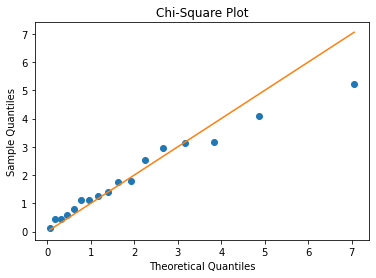

In [9]:
#cqplot
chisq_plot(eps)

In [10]:
#(b) 95% simultaneous confidence interval for E(Y1)
Z_fixed=pd.DataFrame([1,1,1200,140,70,85])
Z_fixed.index=['Z0','Z1','Z2','Z3','Z4','Z5']
Z_fixed

,0
Z0,1
Z1,1
Z2,1200
Z3,140
Z4,70
Z5,85


In [11]:
def simul_conf_int(data, m, r, fixed): #m: number of response var, r: number of predictor var
    Y, Z, B_hat=mv_reg_anal(data, m, r)
    n=len(data)

    #calculate term1
    B_hat.index = ['Z0','Z1','Z2','Z3','Z4','Z5']
    B_hat.columns = ['Y1','Y2']
    fixed.index = ['Z0','Z1','Z2','Z3','Z4','Z5']
    term1 = fixed.T.dot(B_hat).iloc[0,0]
    
    #calculate term2
    eps=Y-Z.dot(B_hat)
    sig_hat = 1/n*eps.T.dot(eps)
    fixed.reset_index(inplace = True, drop = True)
    B_hat.reset_index(inplace = True, drop = True)
    B_hat.index = ['Z0','Z1','Z2','Z3','Z4','Z5']
    term2 = np.sqrt(m*(n-r-1)/(n-r-m)*f.isf(0.05,m,n-r-m))*np.sqrt(fixed.T.dot(np.linalg.inv(Z.T.dot(Z))).dot(fixed).iloc[0,0]*(n/(n-r-1)*sig_hat.iloc[0,0]))
    
    return [term1-term2, term1+term2]

In [12]:
simul_conf_int(amit,2,5,Z_fixed)

[319.0202417848874, 1140.0293024396533]

In [13]:
#(c) 95% simultaneous confidence interval for individual Y2
def pred_int(data, m, r, fixed): #m: number of response var, r: number of predictor var
    Y, Z, B_hat=mv_reg_anal(data, m, r)
    n=len(data)

    #calculate term1
    B_hat.index = ['Z0','Z1','Z2','Z3','Z4','Z5']
    B_hat.columns = ['Y1','Y2']
    fixed.index = ['Z0','Z1','Z2','Z3','Z4','Z5']
    term1 = fixed.T.dot(B_hat).iloc[0,1]
    
    #calculate term2
    eps=Y-Z.dot(B_hat)
    sig_hat = 1/n*eps.T.dot(eps)
    fixed.reset_index(inplace = True, drop = True)
    B_hat.reset_index(inplace = True, drop = True)
    B_hat.index = ['Z0','Z1','Z2','Z3','Z4','Z5']
    term2 = np.sqrt(m*(n-r-1)/(n-r-m)*f.isf(0.05,m,n-r-m))*np.sqrt((1+fixed.T.dot(np.linalg.inv(Z.T.dot(Z))).dot(fixed).iloc[0,0])*(n/(n-r-1)*sig_hat.iloc[1,1]))
    
    return [term1-term2, term1+term2]

In [14]:
pred_int(amit,2,5,Z_fixed)

[-401.0652893243076, 1552.5162238632938]

In [15]:
#(d)
n=17
m=2
r=5

sig_hat = 1/n*eps.T.dot(eps)
sig_hat

,Y1,Y2
Y1,51176.959440,45039.792706
Y2,45039.792706,55335.817611


In [16]:
#(e) Calculate Wilk's lambda value
Z.columns=range(0,6)
E=n*sig_hat
E.index=range(0,2)
E.columns=range(0,2)

#select columns for (Z0, Z1, Z2)
Z_r = Z.iloc[:,:3]
Z_r.columns = ['Z0','Z1','Z2']

#select rows for (Z0, Z1, Z2)
B_hat_r = B_hat.iloc[:3,:]

eps_r=Y-Z_r.dot(B_hat_r)
sig_hat_r = 1/n*eps_r.T.dot(eps_r)

H = n*(sig_hat_r - sig_hat)
HE_inv = H.dot(np.linalg.inv(E))
HE_inv

,0,1
Y1,191.408443,-27.709528
Y2,158.571261,-22.813777


In [17]:
eigval, eigvec = np.linalg.eig(HE_inv)
eigval

array([1.68433265e+02, 1.61401095e-01])

In [18]:
val=1
for i in range(2):
    val=val*1/(1+eigval[i])
    
wilk_ld = val
wilk_ld

0.005081817790983487

In [19]:
#(f) Test hypothesis
q=1
test_stat = -(n-r-1-(m-r+q+1)/2)*np.log(wilk_ld)
test_stat

60.74399185807079

In [20]:
chi2.isf(0.05,m*(r-q))
#test_stat = 60.7439 > 15.5073
#reject null hypothesis

15.507313055865454